# Predicting mobile app user churn



## Introduction

This project was created when I attended a hackathon event which was held in Bangkok. The main objective is to find a way to increase daily active users(DAU) on mobile application. 

Here is a quick overview what the application can do.
- It is the application for fans to follow their favorite artists. They can see feed of artists which is retrieved from facebook and instagram. 


- Users are challenged by collecting exp and coins. They can use them for exchanging rewards like a concert ticket and an exclusive video for the top fans.


- Exp and coins will be given when 
  - Users participate in the feed such as LIKE or COMMENT
  - Users win any missions by answering quizzes


## Data Explanation
Dataset is given in CSV format according to relational database. So we need to merge or join some dataframes to create a final useful dataset. Provided dataset can be briefly summarized into categories below.

### Dynamic data
- User activities

### Static data
- User information
- Feed information
- Artist information
- Mission information

From the business objective, I've decided to use <b>churn prediction</b> which identifies and targets users who are likely to stop using application. These predictive capabilities lead to new insights into user behavior. Business users can then build new engagement strategies to the right customers.

Churn prediction usually depends on user activities or behavior. So we will primarily focus on dynamic data. Here is a data dictionary for user activities table. We will need to extract and create new features from this. Features need to be selected carefully as they need to be meaningful and having an influence on model. 

- userid	varchar(255)		
- action	varchar(255)		
- objecttype	varchar(255)		
- objectid	varchar(65535)		
- ads_on_page	varchar(255)	
- sponsorid	varchar(255)		
- aritstid	varchar(255)		
- time_stamp	timestamp		
- exp	int	
- coin	int	


In our case user activities are  given in a period of 25 days. We will use user activities in the first week to predict whether they will return to application in the following week.

After spending a lot of time to extract useful features, there are six features below 

- Total number of activities
- Total exp
- Total coins
- Inactive period
- Active days
- Membership period

In data preprocessing step will give you more detail how to extract these features from provided dataset

### The process can be divided into 4 steps below.

1. Data exploration : Determine null values
2. Data preprocessing : Create 6 features, verifying multicollinearity and normalization
3. Logistic Regression Model
4. Evaluate and interpret model : Confusion matrix, F1 score and coefficients


## 1. Data Exploration

- Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

- Read user activity file (application_txn.csv) for further analysis. We also need an created time from (user.csv) for calculating membership period feature

In [2]:
#Import user activities information
userActivity = pd.read_csv('DataSource/application_txn.csv',usecols=["userid","objecttype","action","time_stamp2","exp","coin"])
userInformation = pd.read_csv('DataSource/user.csv',usecols=['userid','gender','birth_year','createdtm'])

#Merge between user activity and information table
userMerged = pd.merge(userActivity,userInformation, on='userid')
#Show size of dataframe and previewing some records
print(userMerged.shape)
userMerged.head(5)

(716814, 9)


,userid,action,objecttype,time_stamp2,exp,coin,gender,birth_year,createdtm
0,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 00:04:22.842,0,0,female,2529,2017-06-08 04:58:23.262
1,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 13:54:08.707,0,0,female,2529,2017-06-08 04:58:23.262
2,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 00:02:00.242,0,0,female,2529,2017-06-08 04:58:23.262
3,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 20:19:15.048,0,0,female,2529,2017-06-08 04:58:23.262
4,59391fbfe4b0a0f774fe022e,VIEW,MISSIONPAGE,2017-07-01 20:34:37.440,0,0,female,2529,2017-06-08 04:58:23.262


- Let's see a period of provided dataset

In [3]:
#Find a period of all activities
from datetime import datetime

userMerged['time_stamp2'] = pd.to_datetime(userMerged['time_stamp2'], format = '%Y-%m-%d %H:%M:%S.%f')

startDate = min(userMerged.time_stamp2)
endDate = max(userMerged.time_stamp2)
print("Start date :",startDate)
print("End date:", endDate)
print("Period:", (endDate-startDate).days+1, "days")


Start date : 2017-07-01 00:00:01.688000
End date: 2017-07-25 23:59:58.382000
Period: 25 days


- Exclude all activites related to users who create their account after start date. Because their activites might not enough for training 


In [4]:
userMerged['createdtm'] = pd.to_datetime(userMerged['createdtm'], format = '%Y-%m-%d %H:%M:%S.%f')
userMerged = userMerged[userMerged["createdtm"] < startDate]

#Verify whether the latest account was created before the startDate
print("the latest account was created at:",max(userMerged.createdtm))

the latest account was created at: 2017-06-30 12:53:09.255000


- Define timeline in this case we want to limit the activities within only 1 week (from 2017-07-01 - 2017-07-07)

In [5]:
endDate = datetime.strptime("2017-07-08 00:00:00.000000", '%Y-%m-%d %H:%M:%S.%f')
firstWeekUserMerged = userMerged[userMerged['time_stamp2'] < endDate]
print("the most recent activity is :",max(firstWeekUserMerged.time_stamp2))

firstWeekUserMerged.shape


the most recent activity is : 2017-07-07 23:59:50.638000


(193147, 9)

In [6]:
#find out which column has any missing values
firstWeekUserMerged.isnull().sum()

userid             0
action             0
objecttype     31024
time_stamp2        0
exp                0
coin               0
gender          2194
birth_year     17680
createdtm          0
dtype: int64

In [7]:
#Because gender and age of customers are static infomation which might not related to our case, we exclude them out
firstWeekUserMerged = firstWeekUserMerged.drop(["gender","birth_year"], axis=1)
firstWeekUserMerged.isnull().sum()

userid             0
action             0
objecttype     31024
time_stamp2        0
exp                0
coin               0
createdtm          0
dtype: int64

In [8]:
#Check records where objecttype == null
firstWeekUserMerged[firstWeekUserMerged.objecttype.isnull()].head(5)

,userid,action,objecttype,time_stamp2,exp,coin,createdtm
60,59391fbfe4b0a0f774fe022e,APPIN,NaN,2017-07-01 20:28:41.538,0,0,2017-06-08 04:58:23.262
70,59391fbfe4b0a0f774fe022e,APPIN,NaN,2017-07-01 20:19:14.939,0,0,2017-06-08 04:58:23.262
80,59391fbfe4b0a0f774fe022e,APPOUT,NaN,2017-07-01 13:47:50.472,0,0,2017-06-08 04:58:23.262
84,59391fbfe4b0a0f774fe022e,APPOUT,NaN,2017-07-01 20:34:58.173,0,0,2017-06-08 04:58:23.262
93,59391fbfe4b0a0f774fe022e,APPIN,NaN,2017-07-01 13:54:06.912,0,0,2017-06-08 04:58:23.262


They are open and close application activities which are not associated to any objects like feeds or artists. We will include them as well by counting them as an one activity.

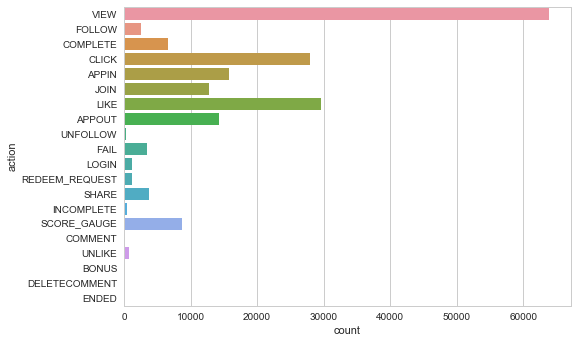

In [9]:
#Review histrogram of customer actions
sns.countplot(y="action",data=firstWeekUserMerged)
plt.show()

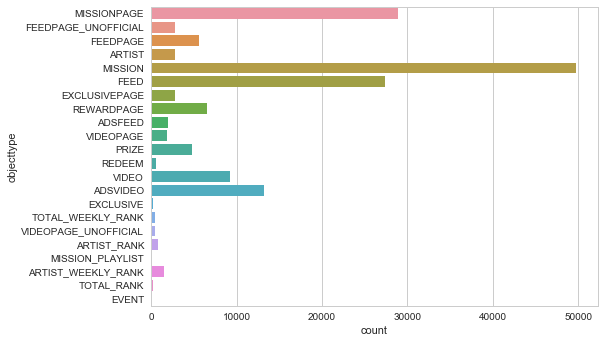

In [10]:
#Review histrogram of customer activities
sns.countplot(y="objecttype",data=firstWeekUserMerged)
plt.show()

Check the number of users. We will use it to cross check with dimension of final dataset 

In [11]:
#Review number of users
numUsers = firstWeekUserMerged[['userid']].drop_duplicates().count()
print("The number of users is :",int(numUsers))

The number of users is : 1247


## 2. Data Preprocessing


We will need to create six features below

- Total number of activities : Count number of activities group 
- Total exp : Sum total exp group 
- Total coins : Sum total coins group
- Inactive period : Number of days from the lastest activity to end of the week
- Active days : Number of days that users have any activities
- Membership peiod : Number of days since created account until start of the week
- y :  y = 1 or churn customer when he/she still has activities in the next week, 0 otherwise


Note. All features are grouped by each user 

#### Inactive, active, membership period and y are represented by images below

<img src="images/timeline.png">



### 2.1. Create total number of activities feature
- We can use groupby function from pandas module to count the number of activities by user. 
- Before moving to next step, let's assure statement of number of users it should be the same as the previous step.

In [12]:
X = firstWeekUserMerged.groupby('userid')["action"].count().reset_index(name="totalAct")
print(X.head(5))
print(X.shape)
assert X.shape[0], numUsers

                     userid  totalAct
0  592da01fe4b0a4ee112b84fb       311
1  592da02be4b09c162d708589       265
2  592da035e4b0a4ee112b8505       499
3  592da070e4b09c162d70859a       417
4  592da096e4b0a4ee112b852a       290
(1247, 2)


### 2.2. Create total exp and coin feature

In [13]:
expAndCoinByUser = firstWeekUserMerged.groupby('userid')["exp","coin"].sum().reset_index()
print(expAndCoinByUser.head(5))
print(expAndCoinByUser.shape)

                     userid   exp  coin
0  592da01fe4b0a4ee112b84fb  3068  2012
1  592da02be4b09c162d708589  1513  1800
2  592da035e4b0a4ee112b8505  3285  4902
3  592da070e4b09c162d70859a     0     0
4  592da096e4b0a4ee112b852a   709  1000
(1247, 3)


- We then store the result into the final dataset and add other features into it by using userid as a key. 

In [14]:
#Merge into X by using userid as a key
X = pd.merge(X, expAndCoinByUser, on="userid")
X.head(5)

,userid,totalAct,exp,coin
0,592da01fe4b0a4ee112b84fb,311,3068,2012
1,592da02be4b09c162d708589,265,1513,1800
2,592da035e4b0a4ee112b8505,499,3285,4902
3,592da070e4b09c162d70859a,417,0,0
4,592da096e4b0a4ee112b852a,290,709,1000


### 2.3 Create inactive period and membership period

- Inactive period = The period from the latest activity time to endDate
- membership period = The period from created account time to startDate

In order to create two features above, we need to find latest activity time by user and created time by user

#### 2.3.1 Latest activity time by user
- Let's group each userid with max function to find the most recent time

In [15]:
latestTimeByUser = firstWeekUserMerged.groupby('userid')['time_stamp2'].max().reset_index(name="recentTime")
latestTimeByUser.head(5)

,userid,recentTime
0,592da01fe4b0a4ee112b84fb,2017-07-06 12:06:45.295
1,592da02be4b09c162d708589,2017-07-06 12:08:26.112
2,592da035e4b0a4ee112b8505,2017-07-07 17:03:38.790
3,592da070e4b09c162d70859a,2017-07-06 12:14:26.016
4,592da096e4b0a4ee112b852a,2017-07-06 12:07:12.875


#### 2.3.2 Created account time
- Find created account time by user

In [16]:
uniqueCreatedTimeByUser = firstWeekUserMerged[['userid','createdtm']].drop_duplicates()
uniqueCreatedTimeByUser.head(5)

,userid,createdtm
0,59391fbfe4b0a0f774fe022e,2017-06-08 04:58:23.262
340,592f8ddfe4b09c162d715525,2017-06-01 10:45:35.769
408,592e1c65e4b09c162d70ac5b,2017-05-31 08:29:09.357
797,5945552ee4b0db45c711c290,2017-06-17 11:13:34.423
1916,593e4481e4b06f7fcb9eabe4,2017-06-12 02:36:33.388


In [17]:
#Merge 2 dataframes above into X
X = pd.merge(X, latestTimeByUser, on="userid")
X = pd.merge(X, uniqueCreatedTimeByUser , on ="userid")
X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438


#### 2.3.3. Create inactive and membership period features
- Create inactivePeriod and memberPeriod features and converting into a number of days

In [18]:
#It is the period between the time last activity took place and end date
X["inactivePeriod"] = endDate - X['recentTime']
#Convert to number of days
X["inactivePeriod"] = X.inactivePeriod.dt.days

#Create new feature of the membership period from the registration date until start date
X["memberPeriod"] = startDate - X["createdtm"]
#Convert to number of days
X["memberPeriod"] = X.memberPeriod.dt.days

X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm,inactivePeriod,memberPeriod
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764,1,31
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470,1,31
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917,0,31
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498,1,31
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438,1,31


### 2.4. Create activeDay feature
- activeDay represents how often users use this application in one week

In [19]:
#Convert time_stamp2 to day of the week
firstWeekUserMerged["day_time_stamp2"] = firstWeekUserMerged.time_stamp2.dt.day

- Count how often users use this application in one week


In [20]:
#Accumulate number of day by user
activityByUserByday = firstWeekUserMerged.groupby('userid')["day_time_stamp2"].value_counts().index.tolist()
activityByUserByday = pd.DataFrame(activityByUserByday,columns=["userid","activeDay"])
activityByUserByday = activityByUserByday.groupby('userid')["activeDay"].count().reset_index()
activityByUserByday.head(5)

,userid,activeDay
0,592da01fe4b0a4ee112b84fb,5
1,592da02be4b09c162d708589,5
2,592da035e4b0a4ee112b8505,7
3,592da070e4b09c162d70859a,5
4,592da096e4b0a4ee112b852a,5


In [21]:
maxActiveDay = max(activityByUserByday["activeDay"])
print("\nThe highest number of active day is :",maxActiveDay,"days")

numberOfUser = activityByUserByday[activityByUserByday["activeDay"]==maxActiveDay].userid.count()
print("There are",numberOfUser,"users who keep playing the mobile application for", maxActiveDay,"days")

#Merge activeDay feature into training data
X = pd.merge(X, activityByUserByday[['userid','activeDay']] , on ="userid")


The highest number of active day is : 7 days
There are 100 users who keep playing the mobile application for 7 days


In [22]:
X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm,inactivePeriod,memberPeriod,activeDay
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764,1,31,5
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470,1,31,5
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917,0,31,7
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498,1,31,5
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438,1,31,5


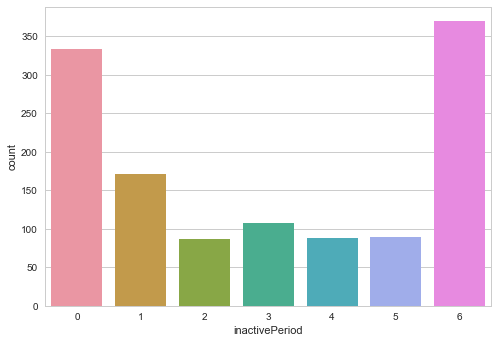

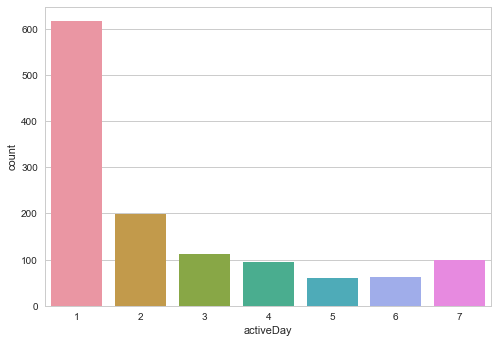

In [23]:
sns.countplot(x="inactivePeriod",data=X)
plt.show()

sns.countplot(x="activeDay",data=X)
plt.show()

The bar charts show that most users use application only first day and leave. 

### 2.5 Label Dataset

- y = 1 : Churn user, he/she has no any activities in the following week.
- y = 0 : Non-churn user, he/she returns to application in the following week.

Get user list from user activities in the next week 

In [24]:
#Define start and end date for next week
nextStartDate = datetime.strptime("2017-07-08 00:00:00.000000", '%Y-%m-%d %H:%M:%S.%f')
nextEndDate = datetime.strptime("2017-07-15 00:00:00.000000", '%Y-%m-%d %H:%M:%S.%f')

#Filter activity within nextweek peiod from predefined date above
nextWeekUserMerged = userMerged.loc[(userMerged['time_stamp2'] >= nextStartDate) & (userMerged['time_stamp2'] < nextEndDate)]
print("the first activity is :",min(nextWeekUserMerged.time_stamp2))
print("the most recent activity is :",max(nextWeekUserMerged.time_stamp2))

#Get only user list within next week period
nextWeekUserList = nextWeekUserMerged[["userid"]].drop_duplicates()
nextWeekUserList = nextWeekUserList["userid"].tolist()
print("Test user list : ",nextWeekUserList[0:5])

the first activity is : 2017-07-08 00:00:00.080000
the most recent activity is : 2017-07-14 23:59:45.156000
Test user list :  ['59391fbfe4b0a0f774fe022e', '592e1c65e4b09c162d70ac5b', '5945552ee4b0db45c711c290', '593e4481e4b06f7fcb9eabe4', '59561beee4b03f87dbd922d6']


- Assign y = 0 when user from the first week is also in the following week, 1 Otherwise

In [25]:
X['y'] = np.where(X["userid"].isin(nextWeekUserList),0 , 1)
X.head(5)

,userid,totalAct,exp,coin,recentTime,createdtm,inactivePeriod,memberPeriod,activeDay,y
0,592da01fe4b0a4ee112b84fb,311,3068,2012,2017-07-06 12:06:45.295,2017-05-30 11:38:55.764,1,31,5,1
1,592da02be4b09c162d708589,265,1513,1800,2017-07-06 12:08:26.112,2017-05-30 11:39:07.470,1,31,5,0
2,592da035e4b0a4ee112b8505,499,3285,4902,2017-07-07 17:03:38.790,2017-05-30 11:39:17.917,0,31,7,0
3,592da070e4b09c162d70859a,417,0,0,2017-07-06 12:14:26.016,2017-05-30 11:40:16.498,1,31,5,0
4,592da096e4b0a4ee112b852a,290,709,1000,2017-07-06 12:07:12.875,2017-05-30 11:40:54.438,1,31,5,0


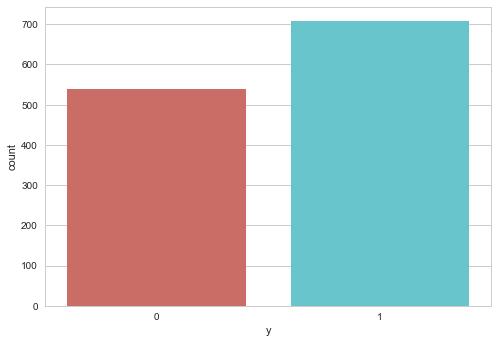

In [26]:
sns.countplot(x="y",data=X,palette='hls')
plt.show()

As expected, most users are classified as churn because the active and inactive period mentioned previously.

### 2.6. Data Verification


- Drop uncessary columns

In [27]:
X.drop(["userid","recentTime","createdtm"], axis=1, inplace=True)

- Check missing values

In [41]:
X.isnull().sum()

totalAct          0
exp               0
coin              0
inactivePeriod    0
memberPeriod      0
activeDay         0
dtype: int64

- Check the independence between independent variables

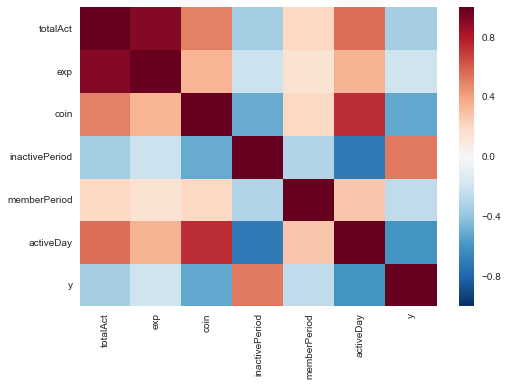

In [29]:
sns.heatmap(X.corr())
plt.show()

The result shows total activities are dependent on exp features. However, the remaining features seem to be fine so we're going to use them for now.

- Exclude y from the X dataframe

In [30]:
y = X.iloc[:,-1]
X = X.iloc[:,0:-1]
#Keep column names of training set.
col_names = X.columns

print(X.head(5))
print("\n",y.head(5))

   totalAct   exp  coin  inactivePeriod  memberPeriod  activeDay
0       311  3068  2012               1            31          5
1       265  1513  1800               1            31          5
2       499  3285  4902               0            31          7
3       417     0     0               1            31          5
4       290   709  1000               1            31          5

 0    1
1    0
2    0
3    0
4    0
Name: y, dtype: int32


- Normalizing each feature for preventing models from misbehaving

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Form the dataframe again after they have been scaled from the previous step
X = pd.DataFrame(X,columns=col_names)
X.head(5)

,totalAct,exp,coin,inactivePeriod,memberPeriod,activeDay
0,0.389479,0.412130,0.353287,-0.795394,1.415386,1.268071
1,0.274714,0.094399,0.231978,-0.795394,1.415386,1.268071
2,0.858519,0.456469,2.006987,-1.201725,1.415386,2.281389
3,0.653938,-0.214750,-0.798009,-0.795394,1.415386,1.268071
4,0.337086,-0.069881,-0.225794,-0.795394,1.415386,1.268071


## 3. Logistic Regression 

- Split the data into training and test sets
- Check out training data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(935, 6)

- Fit logistic regression to the training set

In [33]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 4. Evaluating Model

### 4.1 Predicting the test set results and create confusion matrix

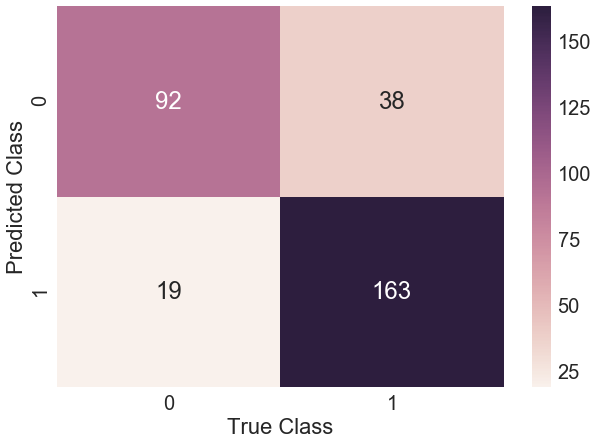

In [34]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.set(font_scale=2)#for label size

plt.figure(figsize = (10,7))
confusion_plot = sns.heatmap(confusion_matrix, annot=True,fmt='g')

confusion_plot.set(xlabel='True Class', ylabel='Predicted Class')

plt.show()


In [35]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


### 4.2. Compute precision, recall, F-measure and support

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.83      0.71      0.76       130
          1       0.81      0.90      0.85       182

avg / total       0.82      0.82      0.81       312



### 4.3. Coefficients

In [37]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, classifier.coef_[0][idx]))

The coefficient for totalAct is -1.1192172582121305
The coefficient for exp is -0.09104972981248576
The coefficient for coin is -0.4022880677777478
The coefficient for inactivePeriod is 0.4186963903512042
The coefficient for memberPeriod is -0.2134103408210591
The coefficient for activeDay is -0.7269480904461145
